In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerated.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('.', 'data')):
    assert name in DATA_HUB, f"{name} not found in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'Downloading {fname} from {url} ...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, f"Only zip/tar file can be decompressed"
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else base_dir

In [5]:
def download_all():
    for name in DATA_HUB:
        download(name)

In [6]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

In [7]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))

In [10]:
data_path = '../data/AmesHousing.txt'
data = pd.read_csv(data_path, sep='\t', header=0)

In [11]:
num_train = data.shape[0] // 2

In [12]:
train_data = data.iloc[:num_train, :].drop('Order', axis=1)
test_data = data.iloc[num_train:, :].drop(['Order', 'SalePrice'], axis=1)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1465, 81)
(1465, 80)


In [14]:
print(train_data.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

         PID  MS SubClass MS Zoning  Lot Frontage Sale Type Sale Condition  \
0  526301100           20        RL         141.0       WD          Normal   
1  526350040           20        RH          80.0       WD          Normal   
2  526351010           20        RL          81.0       WD          Normal   
3  526353030           20        RL          93.0       WD          Normal   

   SalePrice  
0     215000  
1     105000  
2     172000  
3     244000  


In [15]:
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]], axis=0)

In [16]:
print(all_features.shape)

(2930, 79)


In [17]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [18]:
numeric_features

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold'],
      dtype='object')

In [19]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())

In [20]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [21]:
all_features.shape

(2930, 79)

In [24]:
all_features = pd.get_dummies(all_features, dummy_na=True).applymap(lambda x: float(x))
all_features.shape

(2930, 347)

In [25]:
train_features = torch.tensor(all_features[:num_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[num_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [26]:
loss = nn.MSELoss()

In [27]:
in_features = train_features.shape[1]

In [28]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [29]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [30]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [31]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train, X_valid, y_valid = None, None, None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [32]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='Epoch', ylabel='rmse',
                     xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}, 训练log rmse{float(train_ls[-1]):f}, 验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1, 训练log rmse0.153150, 验证log rmse0.201374
折2, 训练log rmse0.159617, 验证log rmse0.159367
折3, 训练log rmse0.166617, 验证log rmse0.184738
折4, 训练log rmse0.164484, 验证log rmse0.151286
折5, 训练log rmse0.171450, 验证log rmse0.170219
5-折验证：平均训练log rmse: 0.163064, 平均验证log rmse: 0.173397


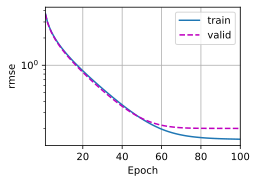

In [33]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

In [34]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='Epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['PID'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse: 0.161607


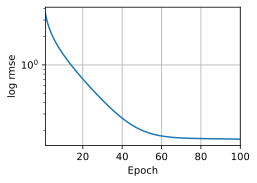

In [35]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

In [36]:
submission = pd.read_csv('submission.csv')

In [37]:
submission.SalePrice

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1460   NaN
1461   NaN
1462   NaN
1463   NaN
1464   NaN
Name: SalePrice, Length: 1465, dtype: float64

In [38]:
submission.shape

(1465, 2)

训练log rmse: 0.161721


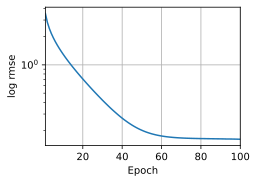

In [39]:
net = get_net()
train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='Epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
print(f'训练log rmse: {float(train_ls[-1]):f}')
preds = net(test_features).detach().numpy()
test_data['SalePrice'] = preds.reshape(1, -1)[0]
submission = pd.concat([test_data['PID'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)

In [40]:
pd.read_csv('submission.csv')

,PID,SalePrice
0,907262070,188905.22
1,907265100,221834.75
2,907285080,230399.06
3,907290150,153943.50
4,907290250,160366.90
...,...,...
1460,923275080,142982.73
1461,923276100,129172.41
1462,923400125,90465.53
1463,924100070,174910.53
